In [61]:
import glob
import cv2
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

emotions = ["anger", "disgust", "fear", "happy", "sadness", "surprise"] #Emotion list

def get_files(emotion): #Define function to get file list, randomly shuffle it and split 80/20
    files = glob.glob("dataset\\%s\\*" %emotion)
    random.shuffle(files)
    training = files[:int(len(files)*0.8)] #get first 80% of file list
    prediction = files[-int(len(files)*0.2):] #get last 20% of file list
    return training, prediction

def make_sets():
    training_data = []
    training_labels = []
    prediction_data = []
    prediction_labels = []
    for emotion in emotions:
        training, prediction = get_files(emotion)
        #Append data to training and prediction list, and generate labels 0-7
        for item in training:
            image = cv2.imread(item) #open image
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #convert to grayscale
            training_data.append(gray) #append image array to training data list
            training_labels.append(emotions.index(emotion))
        for item in prediction: #repeat above process for prediction set
            image = cv2.imread(item)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            prediction_data.append(gray)
            prediction_labels.append(emotions.index(emotion))
    return training_data, training_labels, prediction_data, prediction_labels

In [62]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [63]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [64]:
training_data, training_labels, prediction_data, prediction_labels = make_sets()

batch_size = 8

featuresTrain = torch.from_numpy(np.asarray(training_data)).type(torch.FloatTensor)
targetsTrain = torch.from_numpy(np.asarray(training_labels)).type(torch.LongTensor)

featuresTest = torch.from_numpy(np.asarray(prediction_data)).type(torch.FloatTensor)
targetsTest = torch.from_numpy(np.asarray(prediction_labels)).type(torch.LongTensor)

train = torch.utils.data.TensorDataset(featuresTrain.view(len(training_data),1,224,224),targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest.view(len(prediction_data),1,224,224),targetsTest)

training_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

validation_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

feature_extract = True

model_name = "resnet"

num_classes = len(emotions)

# Number of epochs to train for
num_epochs = 125

model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

model_ft.fc = nn.Linear(512, num_classes)

model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = model_ft.to(device)

error = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.005, momentum=0.09)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

criterion = nn.CrossEntropyLoss()

dataloaders_dict = {'train': training_loader,
    'val': validation_loader}

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Params to learn:
	 conv1.weight
	 fc.weight
	 fc.bias
Epoch 0/124
----------
train Loss: 1.8269 Acc: 0.2558
val Loss: 1.6257 Acc: 0.3750

Epoch 1/124
----------
train Loss: 1.5896 Acc: 0.3811
val Loss: 1.5773 Acc: 0.4792

Epoch 2/124
----------
train Loss: 1.5242 Acc: 0.4194
val Loss: 1.6955 Acc: 0.2812

Epoch 3/124
----------
train Loss: 1.3023 Acc: 0.5294
val Loss: 1.3370 Acc: 0.4688

Epoch 4/124
----------
train Loss: 1.3124 Acc: 0.5090
val Loss: 1.3224 Acc: 0.4167

Epoch 5/124
----------
train Loss: 1.2565 Acc: 0.5217
val Loss: 1.2613 Acc: 0.5208

Epoch 6/124
----------
train Loss: 1.1587 Acc: 0.5601
val Loss: 1.4835 Acc: 0.4479

Epoch 7/124
----------
train Loss: 1.1498 Acc: 0.5908
val Loss: 1.2469 Acc: 0.5312

Epoch 8/124
----------
train Loss: 1.0221 Acc: 0.6215
val Loss: 1.1778 Acc: 0.5521

Epoch 9/124
----------
train Loss: 0.9247 Acc: 0.6957
val Loss: 1.3863 Acc: 0.4375

Epoch 10/124
----------
train Loss: 1.0031 Acc: 0.6522
val Loss: 1.2854 Acc: 0.4896

Epoch 11/124
--------

train Loss: 0.2147 Acc: 0.9488
val Loss: 1.2527 Acc: 0.6250

Epoch 97/124
----------
train Loss: 0.1826 Acc: 0.9463
val Loss: 0.8530 Acc: 0.7292

Epoch 98/124
----------
train Loss: 0.1820 Acc: 0.9591
val Loss: 1.0545 Acc: 0.6875

Epoch 99/124
----------
train Loss: 0.2295 Acc: 0.9361
val Loss: 0.9724 Acc: 0.6979

Epoch 100/124
----------
train Loss: 0.1814 Acc: 0.9488
val Loss: 0.8828 Acc: 0.7292

Epoch 101/124
----------
train Loss: 0.2486 Acc: 0.9258
val Loss: 0.7687 Acc: 0.7708

Epoch 102/124
----------
train Loss: 0.1851 Acc: 0.9642
val Loss: 1.0921 Acc: 0.6458

Epoch 103/124
----------
train Loss: 0.1971 Acc: 0.9514
val Loss: 0.9088 Acc: 0.7188

Epoch 104/124
----------
train Loss: 0.1828 Acc: 0.9361
val Loss: 0.7976 Acc: 0.7292

Epoch 105/124
----------
train Loss: 0.1704 Acc: 0.9668
val Loss: 1.1023 Acc: 0.6250

Epoch 106/124
----------
train Loss: 0.1567 Acc: 0.9514
val Loss: 0.9581 Acc: 0.6979

Epoch 107/124
----------
train Loss: 0.1972 Acc: 0.9335
val Loss: 0.9519 Acc: 0.69

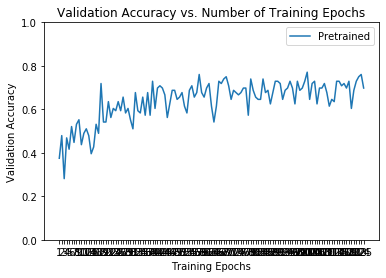

In [65]:
ohist = [h.cpu().numpy() for h in hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [66]:
classes = emotions

In [118]:
import itertools  
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    :param cm: (numpy matrix) confusion matrix
    :param classes: [str]
    :param normalize: (bool)
    :param title: (str)
    :param cmap: (matplotlib color map)
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 8))   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]*100, fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout(5,5,5,(2,2,3.2,3.2))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()

def accuracy_per_class(net):
    
    n_classes = len(emotions)
    # (real, predicted)
    confusion_matrix = np.zeros((n_classes, n_classes), dtype=np.int64)

    for images, labels in validation_loader:
        images, labels = images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(batch_size):
            confusion_matrix[labels[i], predicted[i]] += 1
            label = labels[i]

    print("{:<10} {:^10}".format("Class", "Accuracy (%)"))
    for i in range(n_classes):
        class_total = confusion_matrix[i, :].sum()
        class_correct = confusion_matrix[i, i]
        percentage_correct = 100.0 * float(class_correct) / class_total
        
        print('{:<10} {:^10.2f}'.format(classes[i], percentage_correct))
    return confusion_matrix



In [119]:
confusion_matrix = accuracy_per_class(model_ft)

Class      Accuracy (%)
anger        60.00   
disgust      70.59   
fear         72.73   
happy        90.00   
sadness      72.73   
surprise     86.36   


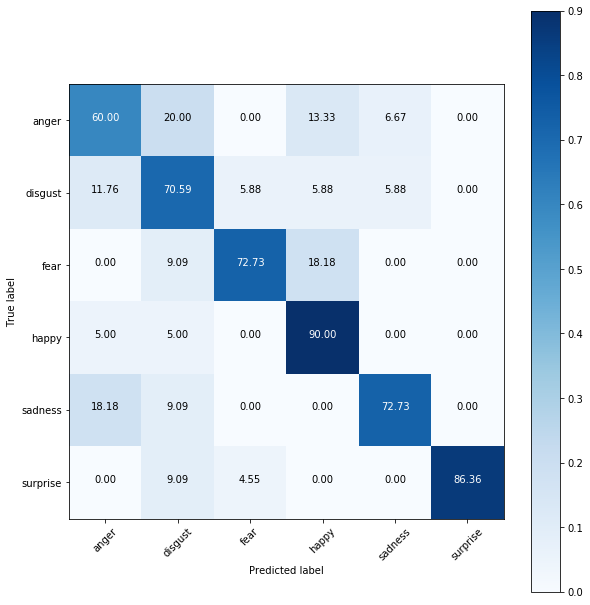

In [120]:
plot_confusion_matrix(confusion_matrix, classes, normalize=True,
                      title='')